In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#Fixing the seed to have repeatablity in results for comparison and model improvement:
np.random.seed(10)

######################################################################################################################
#############################################  DATA CLEANING AND ENGINEERING:   ######################################
import os
data_folder = 'C:\\Users\\Angadvir\\Documents'
data_set = pd.read_csv(os.path.join(data_folder, 'load_temperature_data.csv'))

#Printing and understanding the data_set:
print('Shape of input file data: ', data_set.shape)
print('Printing raw input data file [1st 5 rows]: ')
print(data_set.head(5))
print('')

#Renaming the 1st column:
data_set = data_set.rename(columns={data_set.columns[0]: 'date_form' })

#Dropping redundant column(s) in data_set:
data_set = data_set.drop(data_set.columns[0], axis = 1)

#Splitting the 'date' column into 2 columns ('day' and 'Year') for ease of data prediction:
data_set['day']=[d.split('/')[1] for d in data_set.date]
data_set['year']=[d.split('/')[2] for d in data_set.date]

#Convert all date columns to int64:
data_set['year'] = data_set['year'].astype(np.int64)
data_set['month'] = data_set['month'].astype(np.int64)
                                             
#Dropping the original date columnn:
data_set['date'] = pd.to_datetime(data_set['date'])
data_set = data_set.set_index('date')
#print(data_set.index.get_loc('2013-11-01'))

#data_set = data_set.drop(['date'], axis=1)  
data_set = data_set.loc[:'2013-12-01']

#Storing the Filtering the data set to a new dataframe:
fil_data_set = data_set

#Fill in the NaN values in the 'actual_temperature' column:
fil_data_set['hour']=[d.split(':')[0] for d in data_set.time]

#fil_data_set["actual_temperature"] = fil_data_set.groupby("indicator").transform(lambda x: x.fillna(x.mean()))
fil_data_set['actual_temperature'] = fil_data_set['actual_temperature'].fillna(method='ffill')

#Filtering out the NaN values: 
train_data_set = fil_data_set.dropna()

print('Structure of Modified data set: ')
print(train_data_set.head(5))

####################################################################################################################

Shape of input file data:  (45505, 7)
Printing raw input data file [1st 5 rows]: 
                  Unnamed: 0  actual_kwh  actual_temperature       date  \
0  2012-11-01 01:00:00-07:00         NaN                60.1  11/1/2012   
1  2012-11-01 01:15:00-07:00         NaN                 NaN  11/1/2012   
2  2012-11-01 01:30:00-07:00         NaN                 NaN  11/1/2012   
3  2012-11-01 01:45:00-07:00         NaN                 NaN  11/1/2012   
4  2012-11-01 02:00:00-07:00         NaN                60.1  11/1/2012   

      time  dow  month  
0  1:00:00    3     11  
1  1:15:00    3     11  
2  1:30:00    3     11  
3  1:45:00    3     11  
4  2:00:00    3     11  

Structure of Modified data set: 
            actual_kwh  actual_temperature     time  dow  month day  year hour
date                                                                          
2012-11-02        45.6                55.9  0:15:00    4     11   2  2012    0
2012-11-02        45.9                55.9  0:

#### The data frame is re-structured and modified to take into account the time dependency of energy output levels and temperture. As such, the data-farme is re-ordered by index (=date) of the data frame, to make effective forecasting models of the time-series data set.  
To further explore the depedency of time on the response variable, the 'date' column is split into 'year', 'day' and 'hour', to explore the relationship and strength of dependency of time or 'date' component on 'actual_kwh' values. 

#### Modified DataFrame:
The modified data frame is re-ordered by index or 'date' and contains 8 columns. 

#### Filling 'NaN' 'actual_temperature' values:
The missing 'actual_temperature' values are filled up using a 'forward filling' technique, where the 'NaN' values are filled up using the immediately preceding 'number' values. After exploring the dataset it is obervsed that every hour has at least 1 recorded temperature value and the difference of the temperature values in-between 1 hour intervals is found to be < 1 degree, on average, hence a 'forward filling' technique was considered to be 'good enough' for modelling purposes. 
If, however, 1-hour temperature variations were found to be significant (> 2 degrees), a 'linear interpolation' technique would have been adopted, instead. 

### Exploring relationship between response variable [kwh] and predictor variable(s). 
### Aggregated Plots between 'kwh' and predictor variables
#### Potential Predictor variables:  'actual_temperature',  'time', 'year', 'month', 'dow', 'hour'


Data Set Statictics [Columns]: 
         actual_kwh  actual_temperature           dow         month  \
count  37915.000000        37915.000000  37915.000000  37915.000000   
mean      67.920498           56.978353      3.014849      6.868654   
std       25.716347            7.295646      2.001125      3.523207   
min        0.000000           37.000000      0.000000      1.000000   
25%       48.600000           52.000000      1.000000      4.000000   
50%       57.000000           57.000000      3.000000      7.000000   
75%       83.700000           62.100000      5.000000     10.000000   
max      159.600000           88.000000      6.000000     12.000000   

               year  
count  37915.000000  
mean    2012.848108  
std        0.358921  
min     2012.000000  
25%     2013.000000  
50%     2013.000000  
75%     2013.000000  
max     2013.000000  


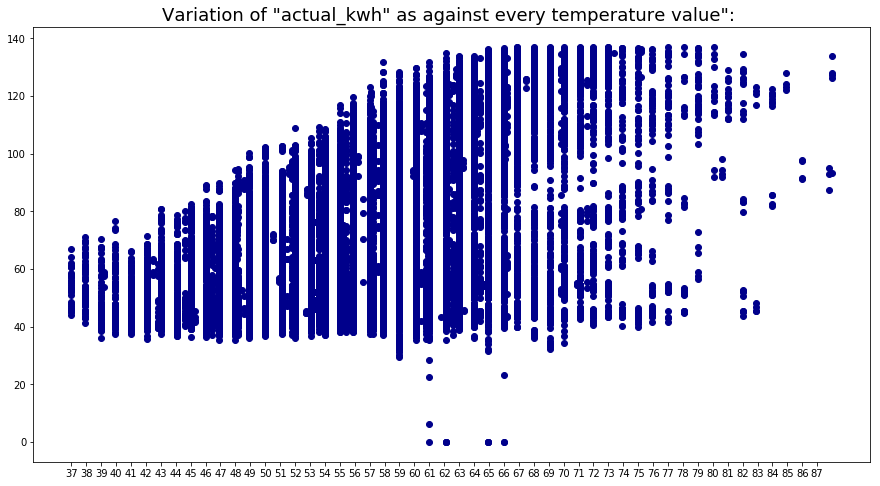

Text(0.5,1,'Mean "actual_kwh" aggregated against "year", variance=[Size of Dot]')

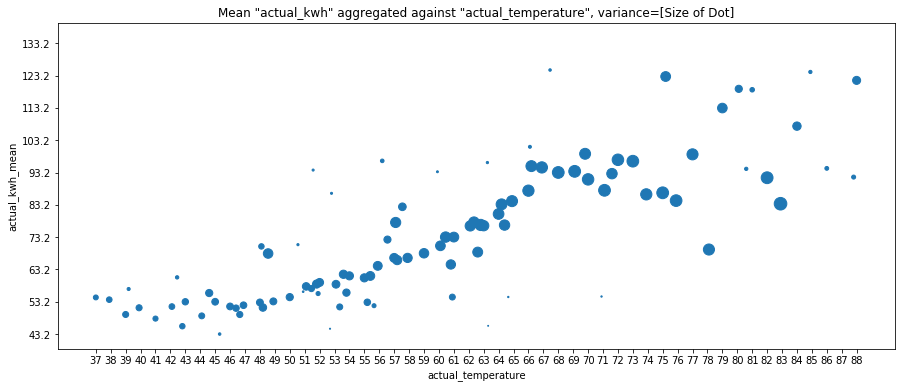

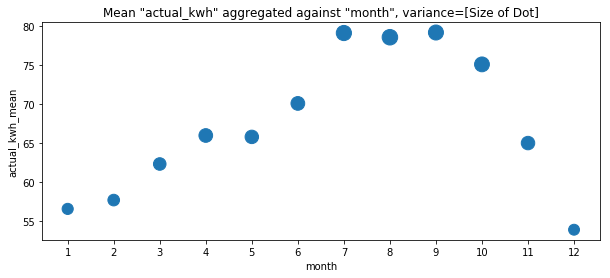

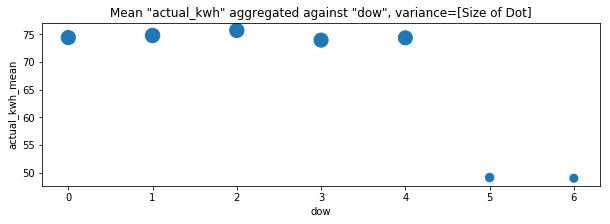

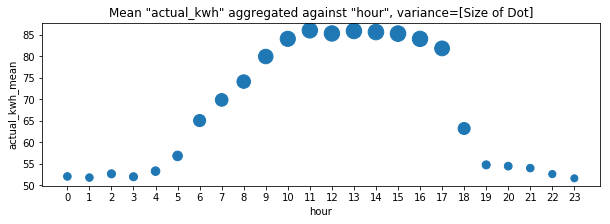

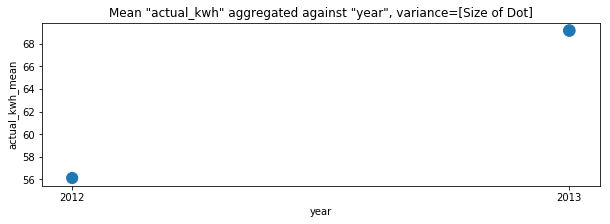

In [3]:
###################################### EXPLORING RELATIONSHIP BETWEEN PREDICTOR AND RESPONSE VARIABLES: #######################################

#print out the data statistics for all columns in the data set to spot OUTLIERS:
print('Data Set Statictics [Columns]: ')
print(train_data_set.describe())
kwh = []
temp = []

#Plot the train_data_set of 'actual_kwh' v.s. 'actual_temperature': 
for j in range(train_data_set['actual_temperature'].shape[0]):
    temp.append(train_data_set.actual_temperature[j]) 

for j in range(train_data_set['actual_kwh'].shape[0]):
    kwh.append(train_data_set.actual_kwh[j])

#Removing Outliers:
q = train_data_set["actual_kwh"].quantile(0.99)
train_data_set = train_data_set[train_data_set["actual_kwh"] < q]

plt.figure(figsize=(15,8))
plt.scatter(train_data_set.actual_temperature, train_data_set.actual_kwh, c='DarkBlue')
plt.title('Variation of "actual_kwh" as against every temperature value": ', size =18)
plt.xticks(np.arange(min(train_data_set.actual_temperature), max(train_data_set.actual_temperature),1))
plt.show()

#Plot the mean and the variance of the 'actual_kwh' at each of the specific temperature ranges:
train_data_stat = train_data_set.groupby('actual_temperature').agg({'actual_kwh': ['mean', 'std']})
train_data_stat.columns = ["_".join(x) for x in train_data_stat.columns.ravel()]

#Fill in NaN with 0 (for zero variance temperatures):
train_data_stat = train_data_stat.fillna(0)

#plot data of the grouped data_set: 
fig, ax = plt.subplots(figsize=(15,6))

#Reseting the index of the 'train_data_stat' to convert into a dataframe:
train_data_stat = train_data_stat.reset_index()
train_data_stat.plot(kind='scatter', x='actual_temperature', y='actual_kwh_mean', s=4*(train_data_stat.actual_kwh_std), ax=ax)
plt.xticks(np.arange(min(train_data_stat.actual_temperature), max(train_data_stat.actual_temperature)+1,1))
plt.yticks(np.arange(min(train_data_stat.actual_kwh_mean), max(train_data_stat.actual_kwh_mean)+1,10))
plt.title('Mean "actual_kwh" aggregated against "actual_temperature", variance=[Size of Dot]', size=12)

#Plotting relationship between 'month' and 'actual_kwh'
train_data_stat_mth = train_data_set.groupby('month').agg({'actual_kwh': ['mean', 'std']})
train_data_stat_mth.columns = ["_".join(x) for x in train_data_stat_mth.columns.ravel()]
train_data_stat_mth = train_data_stat_mth.reset_index()
fig3, ax3 = plt.subplots(figsize=(10,4))
train_data_stat_mth.month = train_data_stat_mth.month.astype(np.int64)
train_data_stat_mth.plot(kind='scatter', x='month', y='actual_kwh_mean', s=8*(train_data_stat_mth.actual_kwh_std), ax=ax3)
plt.xticks(np.arange(min(train_data_stat_mth.month), max(train_data_stat_mth.month)+1,1))
plt.title('Mean "actual_kwh" aggregated against "month", variance=[Size of Dot]', size=12)

#Plotting relationship between 'dow' and 'actual_kwh'
train_data_stat_dow = train_data_set.groupby('dow').agg({'actual_kwh': ['mean', 'std']})
train_data_stat_dow.columns = ["_".join(x) for x in train_data_stat_dow.columns.ravel()]
train_data_stat_dow = train_data_stat_dow.reset_index()
fig2, ax2 = plt.subplots(figsize=(10,3))
train_data_stat_dow.dow = train_data_stat_dow.dow.astype(np.int64)
train_data_stat_dow.plot(kind='scatter', x='dow', y='actual_kwh_mean', s=8*(train_data_stat_dow.actual_kwh_std), ax=ax2)
plt.xticks(np.arange(min(train_data_stat_dow.dow), max(train_data_stat_dow.dow)+1,1))
plt.title('Mean "actual_kwh" aggregated against "dow", variance=[Size of Dot]', size=12)

#Plotting relationship between 'hour' and 'actual_kwh':
train_data_stat_hr = train_data_set.groupby('hour').agg({'actual_kwh': ['mean', 'std']})
train_data_stat_hr.columns = ["_".join(x) for x in train_data_stat_hr.columns.ravel()]
train_data_stat_hr = train_data_stat_hr.reset_index()
fig1, ax1 = plt.subplots(figsize=(10,3))
train_data_stat_hr.hour = train_data_stat_hr.hour.astype(np.int64)
train_data_stat_hr.plot(kind='scatter', x='hour', y='actual_kwh_mean', s=8*(train_data_stat_hr.actual_kwh_std), ax=ax1)
plt.xticks(np.arange(min(train_data_stat_hr.hour), max(train_data_stat_hr.hour)+1,1))
plt.title('Mean "actual_kwh" aggregated against "hour", variance=[Size of Dot]', size=12)

#Plotting relationship between 'year' and 'actual_kwh'
train_data_stat_yr = train_data_set.groupby('year').agg({'actual_kwh': ['mean', 'std']})
train_data_stat_yr.columns = ["_".join(x) for x in train_data_stat_yr.columns.ravel()]
train_data_stat_yr = train_data_stat_yr.reset_index()
fig3, ax3 = plt.subplots(figsize=(10,3))
train_data_stat_yr.year = train_data_stat_yr.year.astype(np.int64)
train_data_stat_yr.plot(kind='scatter', x='year', y='actual_kwh_mean', s=8*(train_data_stat_mth.actual_kwh_std), ax=ax3)
plt.xticks(np.arange(min(train_data_stat_yr.year), max(train_data_stat_yr.year)+1,1))
plt.title('Mean "actual_kwh" aggregated against "year", variance=[Size of Dot]', size=12)
####################################################################################################################

#### The above graphs help in exploring the relationship bewteen 'actual_kwh' and the potential predictor variables. The mean aggregated plots help in evaluating the variation of energy output over various time horizon metrics and as agaist temperature values, in the given temperature range. 
The scatter plot help in guaging the seasonality component of energy (kwh) against time and temperature, respectively and the strength of relationships between energy and the data features (predictor variables).
These variational relationships help in choosing and implementing appropriate predictive modelling techniques for predicting energy output, as well as choosing number of features to be considered for the predictive model. 

#### Comments on relationship between 'actual_kwh' and precitor variables: 
#### Energy vs temperature:
A fairly linear relationship is observed between 'actual_kwh' and 'actual_temperature'. For every increase in temperature recording value, the mean energy output level increases with increased variance (as observed by the increase in the dot size, in the scatter plot). This relationship provides insights into choosing modelling techniques for in-sample and out-of-sample predictions of energy levels. 
#### Energy vs (month, hour):
The energy output, 'actual_kwh' is found to be cyclical in nature, both, with respect to 'hour' and 'month'. Higher enrgy output levels is observed between 9am and 5pm, in a single day. A similar, peak in energy is observed from months of June to October, in a single year. 
#### Energy vs day of week:
The energy level is observed to fluctuate significantly between weekdays and weekends, with a fluctuation of ~ 20 kwh.
Average weekdays Enenrgy (kwh) ~ 70; Average weekends Enenrgy (kwh) ~ 50
##### Energy vs year: 
The energy level for 2012 is expectedly found to be lower than 2013, since the data set contains only the last 2 months of 2012 (having a relatively lower energy output level as against other monnths of the year) and the 1st 11 months of 2013. 


## Creating Train, Validation and Test data sets for model prediction and evaluation.

In [4]:
######################################  CREATING THE TRAIN AND TEST DATA SETS: #######################################
import warnings
warnings.filterwarnings("ignore")

#Creating Train and Test Data Sets: 
from sklearn.model_selection import train_test_split

#Meta data - Training features: 'actual_temperatures', 'dow', 'month', 'year', 'hour':
#Response variable: 'actual_kwh':

#Filter the training data set:
train_data_set_fil = train_data_set[['actual_kwh','actual_temperature','hour','dow','month','year']]

#Sorting the data-frame by index, so the index is monotonic and easy to slice:
train_data_set_fil = train_data_set_fil.sort_index()
y = train_data_set_fil['actual_kwh']
X = train_data_set_fil[['actual_temperature','hour','dow','month','year']]
#Converting hour column into type (int):
X.hour = X.hour.astype(np.int64)

#Filtering out the 'test_data' by aggregating all the 'nan' values in the 'actual_kwh' column:
test_data = fil_data_set[fil_data_set.isnull().any(axis=1)]

#Creating test data_set [features and target variables --> "X_test" & "y_test"] dataset:
X_test = test_data[['actual_temperature','hour','dow','month','year']]
y_test =  test_data[['actual_kwh']]

#Converting hour column into type (int):
X_test.hour =  X_test.hour.astype(np.int64)

#Create training and testing data_sets:
X_train1 = X_val = []
y_train1 = y_val = []
X_train1, X_val, y_train1, y_val = train_test_split(X, y, shuffle=False, test_size=0.25)
print('X_train shape, y_train shape: ', X_train.shape, y_train.shape)
print('X_test shape, y_test shape: ', X_test.shape, y_test.shape)
print('')
####################################################################################################################

NameError: name 'X_train' is not defined

#### All 5 features, 'actual_temperature',  'year', 'month', 'dow', 'hour' are used to predict energy output levels. 
The train and validation split was based on heurestics and the predictive model was evaluated on multiple split ranges of the trainng set [18% - 35%] and the split with the least cross-validation score [rmse score], was chosen for model evaluation. Care was taken that the dataset is Not shuffled while splitting the train and validation sets, to keep time dependancy inherent in the dataset.

### Model Selection: 
#### Initial model tests:
To start off, a straight forward polynomial linear regression model was used on the train set, to capture model accuracy. However, the model reported poor predictive modelling score, with an rmse > 22.000. 
A Regressive Decision Tree model was also reporetd poor accuracy level, with an rmse > 19.000.

#### RandomForestRegressor:
A RandomForestRegressor model was adopted, with an intent to increase predictive power and cross-validation score. The model reported an rmse score between 12 and 14. 

#### LightGBM:
Likewise, a LightGradientBoosting algorithm was also implemented to improve model accuracy on cross-validaton score. The model reported an rmse score between 18 and 20. The advantage of LightGradientBoosting over RF Regressor is that it's a lighter and faster algorithm, providing relatively quick hyperparameter tuning and predictive evaluation on very large datasets.The algorithm replaces continuous values to discrete bins which result in lower memory usage. However, since the model adopts a 'leaf-wise' tree growth inetad of a 'level-wise' tree growth, it sis prone to over-fitting. The 'max_dapth' and 'num_of_leaves' must thus be capped to a certain value while implementing this model.

#### Stacked Model:
With an intent to improve predictive modelling accuracy, a 'stacked model' was developed to further improve the cross-validation score. The idea of the 'stacked model' is to 'train' and 'fit' a 2nd level model on the "predictions" of 2 or more base models/learners [RF regressor and LightGBM] and use the 2nd level 'trained' model to make predcitions on the cross-validation data set. Thus the 'stacked model' would have 2 features, here, [y_pred_model1, y_pred_model2], while training the model, and the 'y_val' as the ground truth cross-valuation scores. The accuracy of the 'stacked model' is evaluated through comparing the predicted energy levels with the cross-validated data set (i.e. 'y_val' vector), using RMSE and MAE as evaluation metrics. 

#### Modelling technique:
Although, it improves precitive modelling accuracy, this technique is prone to over-fitting, due to the nature of the model. To counter over-fitting of the dataset, the 2nd level model, as well as the parameters of the 2nd level model must be tuned appropriately. A simple linear regression 2nd level model would do a good job as the 2nd level model and minimize chances of over-fitting the dataset. 

For this dataset, however, a Random Forest Regressor is implemented, with an intent to maximize model accuracy. However, in doing so, the parameters of the RF Regressor model are chosen so as to reduce the problem of over-fitting and make the model more 'general' to unseen data points. The maximum number of 'decision trees' used in the model is capped at 16, while the 'max_depth' of the trees is capped at 15. 

Another technque of reducing over-fitting is to re-shuffle the train and validation data sets in the split, through K-fold cross-validation. However, the splits Must Be monotonic while splitting the time series data set into 'k' different folds. 
The stacked model reports a significantly higher accuracy value, with an 'rmse' score ranging between 3.5 and 6. The results are documented in the last cell.

#### Other Approaches:
If model transparency and predictive interpretability is preferred over model accuracy, a less complex model such a polynomial regression [displaying predictor coefficient values and intercept] or a Decision Tree Regressor can be chosen, instead. 



## Hyper-Parameter Tuning for the RandomForestRegresssor Model

#### The parameters with the lowest cross-validation error (RMSE value) are chosen to be the RFR parameters used in the 'forecaster' class. A 'grid search' technique is implemented in optimizing the hyper-parameters of the RF Regression model.

In [234]:
'''
def Grid_Search_CV_RFR(X_train1, y_train1):
        from sklearn.model_selection import GridSearchCV
        #from sklearn.ensemble import RandomForestRegressor
        estimator = RandomForestRegressor()
        param_grid = { 
            "n_estimators"      : [50,60,70,80],
            "max_features"      : ["auto", "sqrt", "log2"],
            "max_depth"         : [18,20,22],
            "oob_score"         : [True, False] 
                    }

        grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
        grid.fit(X_train1, y_train1)
        return(grid.best_score_ , grid.best_params_) #STORING THE BEST FOUND PARAMETERS IN 'grid.best_params_' and passing it into the class.        
        
def RFR(X_train1, X_val, y_train1, y_val, best_params):
    from sklearn.ensemble import RandomForestRegressor
    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train1,y_train1)
    y_predict = estimator.predict(X_val)
    print("RMSE score:",np.sqrt(mean_squared_error(y_val,y_predict)))
    return(y_val, y_predict)

for i in range(5):
    print("Loop: " , i+1)
    print("--------------")
    best_score, best_params = Grid_Search_CV_RFR(X_train1, y_train1)
    y_test , y_predict = RFR(X_train1, X_val, y_train1, y_val, best_params)
    print("Best Score:" ,best_score)
    print("Best params:",best_params)
'''

Loop:  1
--------------
RMSE score: 13.06944035216631
Best Score: 0.7625633147125298
Best params: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 70, 'oob_score': True}
Loop:  2
--------------
RMSE score: 13.034344448247785
Best Score: 0.758774069510724
Best params: {'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 70, 'oob_score': False}
Loop:  3
--------------
RMSE score: 14.31706461476474
Best Score: 0.753889347959092
Best params: {'max_depth': 22, 'max_features': 'log2', 'n_estimators': 70, 'oob_score': False}
Loop:  4
--------------
RMSE score: 12.723733190451243
Best Score: 0.7607025327302089
Best params: {'max_depth': 22, 'max_features': 'log2', 'n_estimators': 80, 'oob_score': True}
Loop:  5
--------------
RMSE score: 13.101516267264612
Best Score: 0.7521561501824383
Best params: {'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 80, 'oob_score': True}


### CREATING 2 CLASSES: 'forecaster' & 'forecast_evaluation'

In [13]:
warnings.filterwarnings("ignore")
class forecaster(object):
    def RFReg_fit(self, X_train1, y_train1):
        from sklearn.ensemble import RandomForestRegressor
        self.RF_mod = RandomForestRegressor(n_estimators = 70, max_features = "sqrt", max_depth = 18, random_state = 30)#n_estimators=best_par["n_estimators"], max_depth=best_par["max_depth"], random_state=2, verbose=1)
        self.RF_train = self.RF_mod.fit(X_train1.iloc[:].values, np.ravel(y_train1.iloc[:].values))
        
    def RF_predict(self, X_val):
        self.y_pred_RF = self.RF_train.predict(X_val)
        return(self.y_pred_RF)

    def lgb_fit(self, X_train1, y_train1):
        import lightgbm as lgb
        self.params = {'boosting_type': 'gbdt',
          'max_depth' : 24,
          'objective': 'regression',
          'nthread': 3, # Updated from nthread
          'num_leaves': 40,
          'learning_rate': 0.9,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'metric': 'mean_squared_error'}
        d_train = lgb.Dataset(X_train1, label=y_train1)
        self.reg = lgb.train(self.params, d_train, 1000)
        
    def lgb_predict(self, X_val):
        import lightgbm as lgb
        d_train = lgb.Dataset(X_train1, label=y_train1)
        self.reg = lgb.train(self.params, d_train, 1000)
        self.y_pred_lgb = self.reg.predict(X_val)
        return(self.y_pred_lgb)    

    def stacked_fit(self):
        self.y_pred_RF=self.y_pred_RF.reshape(-1, 1)
        self.y_pred_lgb=self.y_pred_lgb.reshape(-1, 1)
        self.stacked_pred = np.c_[self.y_pred_RF, self.y_pred_lgb]
        self.stack_mod = RandomForestRegressor(n_estimators = 16, max_features = "log2",max_depth = 15, random_state = 30)
        self.stack_train = self.stack_mod.fit(self.stacked_pred, np.ravel(y_val))
        
    def stacked_predict(self):        
        self.stack_pred = self.stack_train.predict(self.stacked_pred)
        return(self.stack_pred, len(self.stack_pred))
    
    def out_of_samp_pred(self, temperature, y_true):
        from statsmodels.tsa.arima_model import ARIMA
        train_size = int(len(temperature) * 0.90)
        self.train, self.test = temperature[0:train_size], temperature[train_size:(train_size+96)]
        self.history = [x for x in self.train]
        self.predictions = list()
        self.axis = []
        for t in range(len(self.test)):
            self.model = ARIMA(self.history, order=(5,1,0))
            self.model_fit = self.model.fit(disp=0)
            self.output = self.model_fit.forecast()
            self.yhat = self.output[0]
            self.predictions.append(self.yhat)
            self.obs = self.test[:t]
            self.history.append(self.obs)
            self.axis.append(t)
        self.rmse = np.sqrt(mean_squared_error(self.test, self.predictions))
        self.mae = mean_absolute_error(self.test, self.predictions)

        #Making energy level predictions on the forecasted temperature using an RF_Regressor model:
        self.prediction_set = []
        self.groundtruth_set = []
        self.prediction_set = X_val.loc[temperature.index[train_size]:temperature.index[(train_size+48)]]
        self.groundtruth_set = y_val.loc[temperature.index[train_size]:temperature.index[(train_size+48)]]
        self.prediction_set = self.prediction_set[:len(self.predictions)]
        self.prediction_set['actual_temperature'] = self.predictions
                
        #Training the model and Predicting the Energy Level 'kwh' on out_of_sample/forecasted temperature values: 
        self.groundtruth_set = self.groundtruth_set[:len(self.prediction_set)]
        self.RF_train_forc = self.RF_mod.fit(self.prediction_set, np.ravel(self.groundtruth_set))
        self.y_forc_RF = self.RF_train_forc.predict(self.prediction_set)
        return(self.y_forc_RF)
        
class forecast_evaluation(forecaster):
    def in_sample_eval(self, x_train, y_train, y_val):
        print('IN SAMPLE EVALUATION SCORES: ')
        super().RFReg_fit(X_train1, y_train1)
        super().RF_predict(X_val)
        self.y_pred = self.y_pred_RF
        self.data = y_val
        self.RFR_rmse = np.sqrt(mean_squared_error(self.y_pred, self.data))
        print('RFR MODEL: ')
        print('RMSE Score: ',self.RFR_rmse)
        self.RFR_mae = mean_absolute_error(self.y_pred, self.data)
        print('MAE Score: ', self.RFR_mae)
        print('')
        
        #LGB MODEL EVALUATION:
        super().lgb_fit(X_train1, y_train1)
        super().lgb_predict(X_val)
        self.y_pred = self.y_pred_lgb
        self.data = y_val
        self.lgb_rmse = np.sqrt(mean_squared_error(self.y_pred, self.data))
        print('LGB MODEL: ')
        print('RMSE Score: ', self.lgb_rmse)
        self.lgb_mae = mean_absolute_error(self.y_pred, self.data)
        print('MAE Score: ', self.lgb_mae)
        print('')
        
        #STACKED MODEL EVALUATION:
        super().stacked_fit()
        super().stacked_predict()
        self.y_pred = self.stack_pred
        self.data = y_val
        self.stacked_rmse = np.sqrt(mean_squared_error(self.y_pred, self.data))
        print('STACKED MODEL: ')
        print('RMSE Score: ', self.stacked_rmse)
        self.stack_mae = mean_absolute_error(self.y_pred, self.data)
        print('MAE Score: ', self.stack_mae)
        print('')

    def out_of_sample_eval(self):
        print('OUT OF SAMPLE EVALUATION SCORES: ')
        super().out_of_samp_pred(temperature, y_val)
        print('Temp prediction RMSE: %.4f' % self.rmse)
        print('Temp prediction MAE: %.4f' % self.mae)
        plt.figure(figsize=(12,5))
        plt.plot(self.axis, self.predictions, label ='forecasted')
        plt.plot(self.axis, self.test, label ='ground_truth' )
        plt.legend()
        plt.title('Comparison between "forecasted" and "ground truth" temp values [24 hours time horizon]', size =14)
        plt.xlabel('time horizon (15-minutes interval)')
        plt.ylabel('Temperature')
        plt.xticks(np.arange(min(self.axis), max(self.axis)+1,4))
        plt.show() 

        self.y_pred = self.y_forc_RF
        self.data = self.groundtruth_set
        self.oos_rmse = np.sqrt(mean_squared_error(self.y_pred, self.data))
        print('RFR MODEL on out-of-sample kwh values: ')
        print('RMSE Score: ', self.oos_rmse)
        self.oos_mae = mean_absolute_error(self.y_pred, self.data)
        print('MAE Score: ', self.oos_mae)
        self.oos_r2 = r2_score(self.y_pred, self.data)
        print('R2 Score: ', self.oos_r2) 
        
        fig, ax = plt.subplots(figsize=(12,5))
        plt.plot(self.axis, self.y_pred, label ='forecasted')
        plt.plot(self.axis, self.data, label ='ground_truth')
        plt.legend()
        plt.title('Comparison between "forecasted" and "ground truth" (kwh) values [24 hours time horizon]', size =14)
        plt.xticks(np.arange(min(self.axis), max(self.axis)+1,4))
        plt.xlabel('time horizon (15-minutes interval)')
        plt.ylabel('Energy [kwh]')
        plt.show() 
        print('')

#### Approach to forecasting out-of-sample data points: 
An ARIMA model was used with p=5, difference=1, q=0 as parameters, to 1st forecast out-of-smaple temperature values. The parameters were decided based on the seasonality, moving average and auto-correlation ('acf' and 'pacf' graphs) of temperature values with respect to time, to set p, d, q values of the ARIMA model. A differencing of 1 (i.e. d=1) made the 'actual_temperature' time series stationary, after which the ARIMA model could be implemented (satisfying 'stationarity' assumption). The ARIMA model was implemented in a loop to forecast only 1 data point at a time, to minimize forecasting error.

The forecasted temperature values and the corresponding time horizon ('date' and 'time' broken to make 4 time based features ['year', 'month','dow','hour']) of the forecast were used as features for making predictions for 'kwh' values. A RF Regressor model was utilized due to make predictions on the response variable, 'kwh', which gave very good model accuracy values [RMSE ~ 2.6] on the cross-validated dataset. A polynomial regression model may also be implemeted here, if model predictibilty and model transparency is preferred over accuracy values. 

### Predicting the missing 'kwh' values in the given data set: 

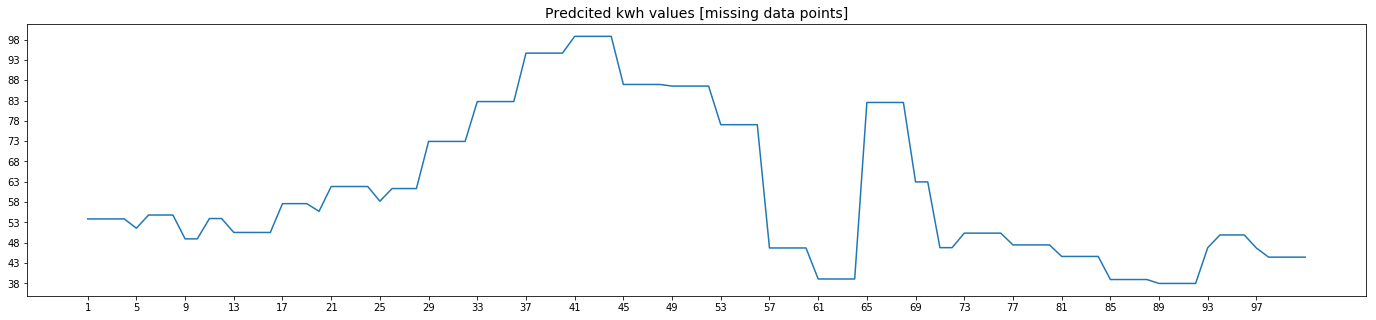

In [6]:
forecasting = forecaster() #Forecasting class.
#CALLING IN-SAMPLE BASE PREDICTIVE MODEL LGB:
#FITTING THE MODELS:
forecasting.lgb_fit(X_train1, y_train1)
#MAKING PREDCITIONS FROM THE 2 BASE PREDICTIVE MODELS:
predicted_val = forecasting.lgb_predict(X_test)

ex= []
#Plotting the missing 'y-values' / 'khw' values: 
for i in range(len(predicted_val)):
    ex.append(i+1)
plt.figure(figsize=(24,5))
plt.plot(ex, predicted_val)
plt.title('Predcited kwh values [missing data points]', size =14)
plt.xticks(np.arange(min(ex), max(ex),4))
plt.yticks(np.arange(min(predicted_val), max(predicted_val),5))
plt.show() 

### Evaluation metrics: 
Since the data set is a time series, choosing the right model evaluaton mtrics is critical. The RMSE (Root Mean Square Error) score and MAE (Mean Absolute Error) values are used to guage predictive model accuracy on the cross-validation data set. The RMSE and MAE provide a good understanding in model accuracy as can be seen from the graph of predicted values and ground truth values (shown in the following cells). Since, the predicted kwh values could potentially include '0' values, an MAPE (Mean Absolute Percentage Error) was not utilized to avoid potential 'inf' values. 

For forecasting out-of-sample kwh values, an R-Squared evaluation metric is also utilized, along with RMSE and MAE scores, to capture the percentage of variation or predictibilty that is captured by the extrapolated data points on the ground truth data points. This helps in guaging the predictibilty strength of the ARIMA model and its parameters, in capturing both seasonlity component and movng average trend in the data points. 

### Implementing the predictive models  and evaluating the in-sample and out-of-sample forecasting error scores:  

In [12]:
forecasting = forecaster() #Forecasting class.
#CALLING IN-SAMPLE BASE PREDICTIVE MODELS:
#FITTING THE 2 BASE MODELS:
forecasting.RFReg_fit(X_train1, y_train1)
forecasting.lgb_fit(X_train1, y_train1)
#MAKING PREDCITIONS FROM THE 2 BASE PREDICTIVE MODELS:
forecasting.RF_predict(X_val)
forecasting.lgb_predict(X_val)

#CALLING THE STACKED [2nd LEVEL] PREDICTIVE MODEL:
forecasting.stacked_fit()
forecasting.stacked_predict()

#CALLING OUT-OF-SAMPLE PREDICTIVE MODEL [ARIMA]:
forecasting.out_of_samp_pred(X_val['actual_temperature'], y_val)

#CALLING THE EVALLUTAION SCORES OF ALL THE MODELS:
evaluater = forecast_evaluation() #Model Evaluation class

#CALLING THE EVALLUTAION SCORES OF IN-SAMPLE PREDECTIVE MODELS:
evaluater.in_sample_eval(X_train1, y_train1, y_val)

#CALLING THE EVALLUTAION SCORES OF OUT-OF-SAMPLE FORECASTING ARIMA MODEL:
evaluater.out_of_sample_eval()

ValueError: could not broadcast input array from shape (2) into shape (1)

#### Key findings: 
1. There's a strong co-relation between Energy level and temperature, with both variables experiencing seasonality. Further, it can be said, that the co-relation is positive, as seen from the aggregated graph earlier. 
2. Variation in energy levels or the seasonality component of energy can be explained by various time metrics. The month of the year and time of the day significantly cause energy levels to fluctuate. The day of the week (i.e. weekdays or weekend), substantially affects the mean energy level through a 24 hour time horizon, with weekends showing significantly smaller energy values (~ 50 kwh on average) as against on weekdays ( ~ 70 kwh on average) 
3. All 5 features, ['actual_temperature', 'year', 'month', 'dow', 'hour'] are found to be significant. Although, over larger time horizons, 'year' may prove to be statistically insignificant due to negligible energy variations betweens years. 
4. Accurate temperature forecasts in subsequent time steps result in high forecasting accuarcy for out-of-sample energy levels. 
5. For predicting in-sample energy levels, a polynomial regression model can be adopted if model interpretability is preferred. However, since few for few specific temperature levels, the mean kwh value is 0, these values (outliers) must be 1st filtered out, before implementing a simpler regression model. Stacking models may also be implemented using simpler regression models for base learners and the 2nd level model (such as a linear regression). this would increase model accuracy, while retaining high results interpretability.